In [1]:
from botchat.utils import *
from termcolor import colored
    
def print_dlg(dlg, max_len=-1):
    dlg = json.loads(dlg)
    chars = 'AB' * 999
    lines = []
    if max_len > 0:
        dlg = dlg[:max_len]
    for c, u in zip(chars, dlg):
        s = f'{c}: {u}' 
        lines.append(colored(s, 'red' if c == 'A' else 'blue'))
    print('\n'.join(lines))

C:\Users\kenny\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
gt_url = 'https://opencompass.openxlab.space/utils/BotChat/GTEval.tsv'
uni_url = 'https://opencompass.openxlab.space/utils/BotChat/UniEval.tsv'
if not osp.exists(gt_url.split('/')[-1]):
    download_file(gt_url)
if not osp.exists(uni_url.split('/')[-1]):
    download_file(uni_url)

In [3]:
GTEval = load(gt_url.split('/')[-1])

In [4]:
def print_GTEval(line):
    print(colored(f'CMP_INDEX: {line["cmp_index"]}', attrs=['bold']))
    max_len = min(len(json.loads(line['conversation1'])), len(json.loads(line['conversation2'])))
    print(colored(f'Model A: {line["A"]}', attrs=['bold']))
    print_dlg(line['conversation1'], max_len)
    print(colored(f'Model B: {line["B"]}', attrs=['bold']))
    print_dlg(line['conversation2'], max_len)
    print(colored('GPT-4 Evaluation', attrs=['bold']))
    print(colored(line['gpt4'], color='green'))

In [5]:
print_GTEval(GTEval.iloc[100])

CMP_INDEX: MT-10;GT;gpt35
Model A: GT
A: Your garden looks beautiful this summer, the flowers are really colorful.
B: Thank you. I have roses, tulips and daffodils. Do you like the rockery with the small flowers?
A: Yes, I do. Those are violets are they?
B: Yes, they are. This afternoon I'm going to water these flowers.
A: The lower branches on that tree are hanging very low. Would you like me to cut them off for you?
B: Thank you. That would be very kind of you. I have a saw in the garden shed.
A: When the lower branches are removed you'll be able to sit under the tree.
B: Tomorrow, I'll cut the grass. Then the garden will look perfect.
A: Just make sure children don't play in the flower beds and destroy the flowers.
Model B: gpt35
A: Your garden looks beautiful this summer, the flowers are really colorful.
B: Thank you. I have roses, tulips and daffodils. Do you like the rockery with the small flowers?
A: Yes, I absolutely love the rockery with the small flowers! It adds such a charm

In [6]:
from botchat.analyze import analyze
ret = analyze('GTEval.tsv', None, return_table=True)

ret = ret['stats']
ret['WinRate'] = [float(x[:-1]) for x in ret['WinRate']]
ret['TieRate'] = [float(x[:-1]) for x in ret['TieRate']]
ret.pop('LoseRate')
ret.pop('NotBadRate')
ret.pop('Score')
ret = pd.DataFrame(ret)

ret = ret.iloc[1:]
ret['WinTie'] = [x + y for x, y in zip(ret['WinRate'], ret['TieRate'])]
ret = ret.sort_values('WinTie')
ret = ret.iloc[::-1]

6216 comparisons in all, while 6216 comparisons are meaningful (two options not exactly the same)
6216 comparisons in all, succeed to extract 6216 answers from judge LLM responses, the successful rate is 100.00%
### Statistics [win / tie / lose / not bad / score (init=0, win +3, both +1, neither -1, lose -3)]
### Score is normalized by the number of comparisons, the normalized range is [-3, 3]
+----+-------------------+---------+---------+----------+------------+----------------------+
|    |       Model       | WinRate | TieRate | LoseRate | NotBadRate |        Score         |
+----+-------------------+---------+---------+----------+------------+----------------------+
| 0  |        GT         |  57.1%  |  26.4%  |  16.6%   |   83.4%    |  1.4777992277992278  |
| 1  |       gpt4        |  26.4%  |  46.8%  |  26.8%   |   73.2%    | 0.45495495495495497  |
| 13 |  vicuna-13b-v1.5  |  22.3%  |  45.7%  |  32.0%   |   68.0%    | 0.16666666666666666  |
| 9  |   qwen-14b-chat   |  20.3%  |  4

In [7]:
model_map = {
    'gpt4': 'GPT-4', 
    'gpt35': 'GPT-3.5-Turbo', 
    'claude2': 'Claude-2',
    'internlm-7b-chat': 'InternLM-7B',
    'internlm-20b-chat': 'InternLM-20B',
    'qwen-7b-chat': 'Qwen-7B', 
    'qwen-14b-chat': 'Qwen-14B',
    'llama2-7b': 'LLaMA2-7B',
    'llama2-13b': 'LLaMA2-13B',
    'llama2-70b': 'LLaMA2-70B',
    'chatglm2-6b': 'ChatGLM2-6B', 
    'baichuan2-13b': 'Baichuan2-13B',
    'vicuna-7b-v1.5': 'Vicuna-7B',
    'vicuna-13b-v1.5': 'Vicuna-13B',
}

<ipython-input-13-b85a02811b57>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


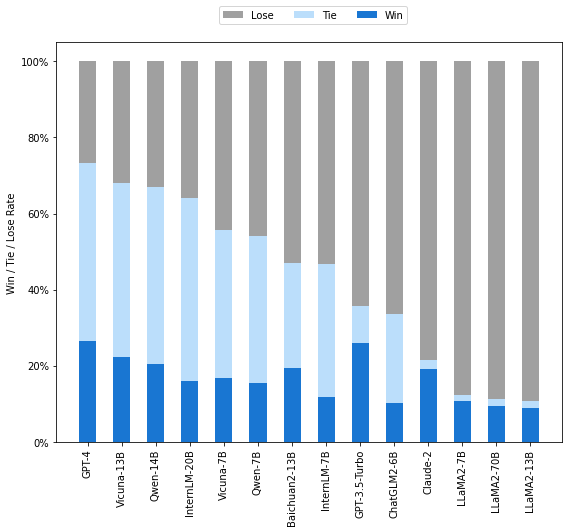

In [13]:
import matplotlib.pyplot as plt

x = np.arange(len(ret['Model']))  # 获取X轴标签位置
labels = list(ret['Model'])
labels = [model_map[x] if x in model_map else x for x in labels]

width = 0.5  # 设置柱状图的宽度
fig, ax = plt.subplots(figsize=(8, 7))

rects1 = ax.bar(x, [100] * len(x), width, label='Lose', color='#A0A0A0')
rects2 = ax.bar(x, list(ret['WinTie']), width, label='Tie', color='#BBDEFB')
rects3 = ax.bar(x, list(ret['WinRate']), width, label='Win', color='#1976D2')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)

# ax.set_title('Figure 5. Win / Tie / Lose Rate when compared to GT.', font=fontP, pad=40)

ax.set_ylabel('Win / Tie / Lose Rate')
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.06), ncols=3)
fig.tight_layout()
plt.show()

In [9]:
UniEval = load('UniEval.tsv')

In [10]:
UniEval

,model,qidx,index,conversation,gpt4
0,GT,MT-1,MT-1;GT,"[""You look rather pale. Are you feeling well?""...",Choice: No\nIndex: None\nReason: The conversat...
1,gpt4,MT-1,MT-1;gpt4,"[""You look rather pale. Are you feeling well?""...",Choice: No\nReason: The conversation is smooth...
2,claude2,MT-1,MT-1;claude2,"[""You look rather pale. Are you feeling well?""...",Choice: Yes\nIndex: 3\nReason: The conversatio...
3,gpt35,MT-1,MT-1;gpt35,"[""You look rather pale. Are you feeling well?""...",Choice: Yes\nIndex: 9\nReason: The conversatio...
4,internlm-7b-chat,MT-1,MT-1;internlm-7b-chat,"[""You look rather pale. Are you feeling well?""...",Choice: Yes\nIndex: 9\nReason: The conversatio...
...,...,...,...,...,...
8200,vicuna-7b-v1.5,MT-884,MT-884;vicuna-7b-v1.5,"[""Patrick, how do you like your roommate?"", ""I...",Choice: No\nReason: The conversation is fluent...
8201,vicuna-13b-v1.5,MT-885,MT-885;vicuna-13b-v1.5,"[""Why are you so late for home from school, Da...",Choice: Yes\nIndex: 13\nReason: In the 13th ch...
8202,vicuna-7b-v1.5,MT-885,MT-885;vicuna-7b-v1.5,"[""Why are you so late for home from school, Da...",Choice: No\nReason: The conversation is smooth...
8203,vicuna-13b-v1.5,MT-886,MT-886;vicuna-13b-v1.5,"[""The construction in front of our building ha...",Choice: No\nReason: The conversation is smooth...


In [12]:
def parse_output(output):
    output = output.split('\n')
    ret = dict()
    ans, index, reason = -1, 16, ''
    for l in output:
        if 'Choice: Yes' in l:
            ans = 1
        elif 'Choice: No' in l:
            ans = 0
        elif 'Index:' in l:
            idx = l.split(': ')[1]
            if idx != 'None':
                index = int(idx) - 1
        elif 'Reason:' in l:
            reason += l.split('Reason: ')[1]
        else:
            reason += l
    return dict(ans=ans, index=index, reason=reason)

def parse_data(data):
    flags = defaultdict(list)
    scores = defaultdict(list)
    data = data[data['model'].isin(model_map)]
    lt = len(data)
    data['model'] = [model_map[x] for x in data['model']]
    for i in range(lt):
        item = data.iloc[i]
        if item['qidx'] not in flags['index']:
            flags['index'].append(item['qidx'])
            scores['index'].append(item['qidx'])
        model = item['model']
        res = parse_output(item['gpt4'])
        flags[model].append(res['ans'])
        scores[model].append(res['index'])   
    return pd.DataFrame(flags), pd.DataFrame(scores)

def calc_acc(scores, skip=[]):
    res = defaultdict(dict)
    for k in [4, 8, 12, 16]:
        for model in scores.keys():
            if model in skip:
                continue
            if model not in ['index', 'GT']:
                res[k][model] = np.mean(scores[model] >= k) * 100
    return res

flags, scores = parse_data(UniEval)

<ipython-input-12-12de0f0a44a6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['model'] = [model_map[x] for x in data['model']]


<ipython-input-14-44daa78217f7>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


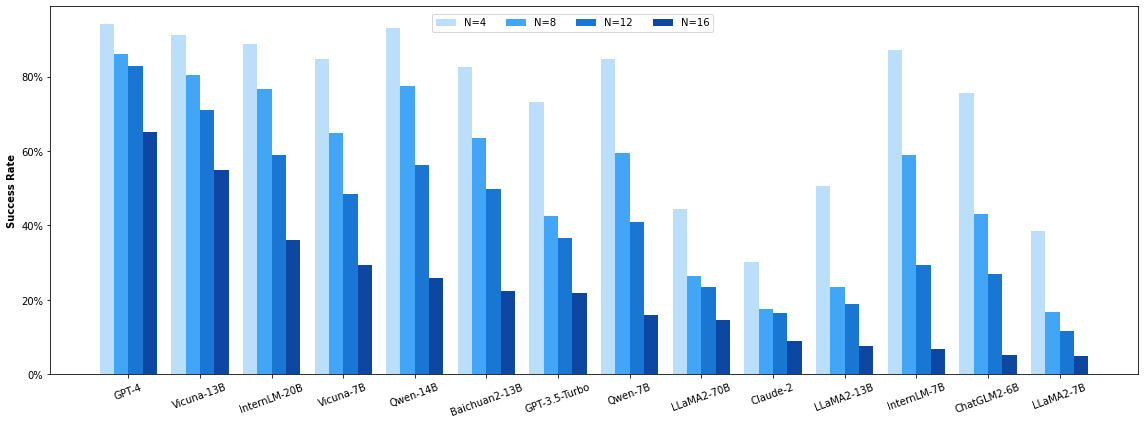

In [14]:
acc = calc_acc(scores)
keys = list(acc[16].keys())
keys.sort(key=lambda x: -acc[16][x])

x = np.arange(len(keys))  # 获取X轴标签位置
labels = keys

width = 0.2  # 设置柱状图的宽度
fig, ax = plt.subplots(figsize=(16,6))

for k in acc:
    acc[k] = [acc[k][m] for m in keys]

rects1 = ax.bar(x - width * 1.5, acc[4], width, label='N=4', color='#BBDEFB')
rects2 = ax.bar(x - width * 0.5, acc[8], width, label='N=8', color='#42A5F5')
rects3 = ax.bar(x + width * 0.5, acc[12], width, label='N=12', color='#1976D2')
rects4 = ax.bar(x + width * 1.5, acc[16], width, label='N=16', color='#0D47A1')

# 添加一些文本标签，例如x和y轴标签以及标题
ax.set_xlabel('',  fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels,  rotation=20)

# ax.set_title('Figure 2. The pass rate of different LLMs when generating a conversation with N chats', font=fontP, pad=15)

ax.set_ylabel('Success Rate',  fontweight='bold')
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

fig.legend(ncols=4, loc='outside upper center', bbox_to_anchor=(0.5, 0.97))
fig.tight_layout()
plt.show()